In [1]:
folder_names = {"case39bus9gen_halfperturb", "case39bus10gen_onetenthperturb"}

In [9]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import coo_array

from os import path


# ## Loading data

# In[2]:


#Name of the folder with the time series and other files
folder_name_1 = "case39bus9gen_halfperturb"
# folder_name_1 = "case39bus10gen_onetenthperturb"
# folder_name_1 = "case_39bus10gen_newengland"

#Name that needs to be appending to the beginning of other files
folder_name = "case_39bus10gen_newengland"
folder_location = path.join("powergrid","Datasets", folder_name_1)


# data_matrix_df_1 = pd.read_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)))

# data_matrix_df_2 = pd.read_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)))

# data_matrix_df_3 = pd.read_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)))

# #### Reading time series data and skipping rows to sub sample

# In[3]:


# #Trimming original time series to reduce the number of data points
# data_matrix_df_orig = pd.read_csv(path.join(folder_location, "{}_timeseries.csv".format(folder_name)))
# skip_n_rows_btw = 10
# rows_to_keep = np.arange(0, len(data_matrix_df_orig), skip_n_rows_btw)

# data_matrix_df = data_matrix_df_orig.iloc[rows_to_keep].reset_index(drop=True)

# data_matrix_df.to_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)), index=False)


# In[4]:


data_matrix_df_up = pd.read_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)))



# In[5]:




# In[6]:


def get_node_index(label):
    if len(label) >0 and label[-1].isnumeric():
        return get_node_index(label[:-1]) + label[-1]
    else:
        return ""

def node_label_changer(column_label):
    node_index = get_node_index(column_label)
    if "PhaseGenTerm" in column_label:
        new_label = "Phi_T_{}".format(node_index)
    elif "PhaseGen" in column_label:
        new_label = "Phi_G_{}".format(node_index)
    elif "PhaseLoad" in column_label:
        new_label = "Phi_L_{}".format(node_index)
    elif "FreqGenTerm" in column_label:
        new_label = "om_T_{}".format(node_index)
    elif "FreqGen" in column_label:
        new_label = "om_G_{}".format(node_index)
    elif "FreqLoad" in column_label:
        new_label = "om_L_{}".format(node_index)
    elif "ActivePowerGenTerm" in column_label:
        new_label = "P_T_{}".format(node_index)
    elif "ActivePowerGen" in column_label:
        new_label = "P_G_{}".format(node_index)
    elif "ActivePowerLoad" in column_label:
        new_label = "P_L_{}".format(node_index)
    elif "ReactivePowerGenTerm" in column_label:
        new_label = "Q_T_{}".format(node_index)
    elif "ReactivePowerGen" in column_label:
        new_label = "Q_G_{}".format(node_index)
    elif "ReactivePowerLoad" in column_label:
        new_label = "Q_L_{}".format(node_index)
    else:
        new_label = column_label
    return new_label


# In[7]:


column_label_dict = {column: node_label_changer(column) for column in data_matrix_df_up.columns}
column_label_dict


# In[8]:


# new_column_names = ["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
#                    "om_0", "om_1", "om_2", "om_3","om_4", "om_5", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5",
#                    "Q_0", "Q_1", "Q_2", "Q_3", "Q_4", "Q_5"]

#Renaming the state variables for compactness
data_matrix_df_up.rename(columns= column_label_dict, inplace=True)


# In[9]:


power_features = [feature for feature in data_matrix_df_up.columns if "P_" in feature]
freq_features = [feature for feature in data_matrix_df_up.columns if "om_" in feature]
phase_features = [feature for feature in data_matrix_df_up.columns if "Phi_" in feature]

K_features = [feature[2:] for feature in power_features]


# In[10]:


#Removing Reactive power from the timeseries they are not needed for fitting 
non_reactive_columns = [column for column in data_matrix_df_up.columns if "Q" not in column]

data_matrix_df_up = data_matrix_df_up[non_reactive_columns]


# In[11]:


# data_matrix_df


# ## Trimming the time

# In[12]:

In [3]:
# noise_percent_list = [0,0.0001,0.001,0.01, 0.1]
noise_percent_list = [0,0.0001,0.001,0.01]

noise_percent_list = [0.001]

# noise_percent_list = [0]

result_dict = {}

# perturbation_num_param = 25
perturbation_num_param = 10

final_time_list = np.linspace(2.9,199.9,perturbation_num_param)
final_time_list

array([  2.9       ,  24.78888889,  46.67777778,  68.56666667,
        90.45555556, 112.34444444, 134.23333333, 156.12222222,
       178.01111111, 199.9       ])

In [4]:
# result_df = pd.DataFrame.from_dict(dict(zip(num_perturb_list, incorrect_terms_list)), orient='index', columns=["#Incorrect relationship"])

# result_df.index.name = "#Perturbations"

# result_df

In [5]:
num_perturb_list = []
incorrect_terms_list = []
# num_random_seeds = 10
num_random_seeds = 10

for noise_perc_value in noise_percent_list:
    for ran_seed_index in range(num_random_seeds):
        print("Currently at {} noise_level, {} ran_seed_index".format(noise_perc_value, ran_seed_index))
        #Setting the random seed
        np.random.seed(100+num_random_seeds)

        
        result_dict[noise_perc_value] = {}
        #Adding noise to the clean time series        
        noise_perc = noise_perc_value
        # data_matrix_df_list = [data_matrix_df]
        num_time_points = len(data_matrix_df_up)
        data_matrix_features = data_matrix_df_up.columns
        t_exact = data_matrix_df_up["time"]
        noise_arr = np.random.normal(size=data_matrix_df_up.shape)
        noisy_data_df = data_matrix_df_up + (noise_perc/100)*(abs(data_matrix_df_up))*noise_arr
        noisy_data_df["time"] = t_exact
        
        for final_time in final_time_list:
            # final_time = 151.9
            
            
            # In[13]:
            
            
            data_matrix_df = noisy_data_df[noisy_data_df["time"] <= final_time]
            
            
            # data_matrix_df[phase_features].plot()
            
            # In[14]:
            
            
            data_matrix_df
            
            
            # In[15]:
            
            
            # data_matrix_df[power_features].sum(axis=1).plot()
            
            
            # ### Reading gamma values 
            
            # In[16]:
            
            
            gamma_df = pd.read_csv(path.join(folder_location, "{}_gamma.csv".format(folder_name)), names=K_features)
            
            
            # In[17]:
            
            
            gamma_df
            
            
            # ### Splitting the time-series with respect to the perturbation points
            
            # In[18]:
            
            
            #Getting perturbations time points
            perturbation_points_df = pd.read_csv(path.join(folder_location, "{}_timepoints.csv".format(folder_name)))
            
            perturbation_points_df = perturbation_points_df[perturbation_points_df["Perturbation timepoints"] <= final_time]
            
            
            # In[19]:
            
            
            perturbation_time_point_list = perturbation_points_df["Perturbation timepoints"]
            # perturbation_time_point_list
            
            
            # In[20]:
            
            
            # perturbation_time_point_list
            
            
            # In[21]:
            
            
            print("Number of perturnations:{}".format(len(perturbation_time_point_list)))
            num_perturb_list.append(len(perturbation_time_point_list))
            
            
            # In[22]:
            
            
            #Splitting the data_matrix with the timeseries into a list of timeseries dataframes based on where the perturbation is introduced
            #The purpose of this step is to smoothen each of perturbation segment independently using splines and find the derivaties
            #This will avoid jumps in the derivative due to the discontinuity at the perturbanc time point
            
            data_matrix_df_list =[data_matrix_df[(ind_i < data_matrix_df["time"]) & (data_matrix_df["time"] < ind_j) ] 
                                   for ind_i, ind_j in zip(perturbation_time_point_list[:-1], perturbation_time_point_list[1:])]
            
            
            data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)
            
            data_matrix_df_appended
            
            
            # #### Loading admittance matrix, Y
            
            # In[23]:
            
            
            admittance_Y_df = pd.read_csv(path.join(folder_location, "{}_Y.csv".format(folder_name)), names=K_features)
            admittance_Y_df.set_index(pd.Index(K_features), inplace=True)
            for column in admittance_Y_df.columns:
                admittance_Y_df[column] = admittance_Y_df[column].apply(lambda x: x.replace('i', 'j'))
            
            
            # In[24]:
            
            
            admittance_Y_df
            
            
            # #### Loading static parameters
            
            # In[25]:
            
            
            static_param_df = pd.read_csv(path.join(folder_location, "{}_staticparams.csv".format(folder_name)))
            
            
            # In[26]:
            
            
            static_param_df
            
            
            # #### Loading coupling matrix, K
            
            # In[27]:
            
            
            coupling_K_df = pd.read_csv(path.join(folder_location, "{}_K.csv".format(folder_name)), names=K_features)
            coupling_K_df.set_index(pd.Index(K_features), inplace=True)
            
            
            # In[28]:
            
            
            coupling_K_df
            
            
            # In[29]:
            
            
            coupling_matrix_true = coupling_K_df .to_numpy()
            coupling_matrix_true
            
            
            # In[30]:
            
            
            gamma_matrix = gamma_df.to_numpy()
            admittance_Y_matrix = admittance_Y_df.to_numpy()
            
            gamma_matrix
            
            
            # In[31]:
            
            
            coupling_matrix_init = np.ones(admittance_Y_matrix.shape)
            # coupling_matrix_init = np.zeros(admittance_Y_matrix.shape)
            # coupling_matrix_init[3,:] = 1
            
            coupling_matrix_init = np.triu(coupling_matrix_init, 0)
            coupling_matrix_init
            sparse_coupling_matrix_init = coo_array(coupling_matrix_init)
            sparse_coupling_matrix_init.toarray()
            
            
            # ## Smoothening data and finding derivatives using splines
            
            # In[32]:
            
            
            # from dae_finder import add_noise_to_df
            
            # noise_perc = noise_perc_value
            # # data_matrix_df_list = [data_matrix_df]
            # num_time_points = len(data_matrix_df_list[0])
            # data_matrix_features = data_matrix_df_list[0].columns
            # for ind, data_matrix_ in enumerate(data_matrix_df_list):
            #     t_exact = data_matrix_["time"]
            #     # noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
            #     noise_arr = np.random.normal(size=data_matrix_.shape)
            #     noisy_data_df = data_matrix_ + (noise_perc/100)*(abs(data_matrix_))*noise_arr
                
            #     noisy_data_df["time"] = t_exact
            #     data_matrix_df_list[ind] = noisy_data_df
            
            
            # In[33]:
            
            
            # from copy import deepcopy
            # from scipy import interpolate
            # from dae_finder import der_label 
            # import itertools
            # def smooth_data(data_matrix,
            #                 domain_var="t",
            #                 smooth_method ="spline",
            #                 s_param_=None,
            #                 noise_perc=0,
            #                 derr_order=1,
            #                 eval_points=[],
            #                 num_time_points=0):
            #     """
            #     :param data_matrix: Data matrix to smoothen. nxp data frame structure is assumed where n is the number of
            #                         data points and p is the number of features (predictors).
            #     :param domain_var: Domain variable with respect to which the data needs to be smoothened. Default is assumed to be
            #                         "t" (time).
            #     :param smooth_method: Numerical method used for smoothening.
            #     :param s_param: smoothening parameter.
            #     :param noise_perc: optional estimate of noise to signal ratio %
            #     :param derr_order: Number of derivatives need to be calculated, wrt the domain variable, after smoothening the data.
            #     :param eval_points: option list of points at which the smoothened data and derivatives will be evaluated for output
            #     :return: pd.DataFrame of size len(eval_points) x k where k is the number of features and their derivatives.
            #     """
            #     assert domain_var in data_matrix, "domain variable not found in the data matrix"
            #     s_param = deepcopy(s_param_)
            #     data_t = data_matrix[domain_var]
            #     if num_time_points == 0:
            #         num_time_points = len(data_matrix)
            #     if len(eval_points) == 0:
            #         eval_points = np.linspace(data_t.iloc[0], data_t.iloc[-1], num_time_points)
            #     t_eval_new = eval_points
            
            #     data_matrix_ = data_matrix.drop(domain_var, axis=1)
            #     data_matrix_std = data_matrix_.std()
            
            #     data_matrix_smooth = pd.DataFrame(t_eval_new, columns=[domain_var])
            
            #     if smooth_method == "spline":
            #         if s_param:
            #             s_param_list = [s_param for feature in data_matrix_]
            #         else:
            #             s_param_list = [num_time_points * (0.01 * noise_perc * data_matrix_std[feature]) ** 2 for
            #                             feature in data_matrix_]
            #         smoothened_values_list = [np.hstack([interpolate.splev(t_eval_new, interpolate.splrep(data_t,
            #                                                                                               data_matrix_[feature],
            #                                                                                               s=s_param_val), der=der_ind) [:, None]
            #                                              for der_ind in range(derr_order + 1)])
            #                                   for feature, s_param_val in zip(data_matrix_, s_param_list)]
            #         smoothened_values = np.hstack(smoothened_values_list)
            #         column_label_list = [[der_label(feature, der_ind) for der_ind in range(derr_order + 1)]
            #                              for feature in data_matrix_]
            #         column_label_list = list(itertools.chain.from_iterable(column_label_list))
            #         print(len(column_label_list))
            #         print(smoothened_values.shape)
            #         smoothened_df = pd.DataFrame(smoothened_values, columns=column_label_list)
            #         data_matrix_smooth = pd.concat([data_matrix_smooth, smoothened_df], axis=1)
            
            #         # for feature in data_matrix_:
            #         #     if not s_param:
            #         #         # smoothing parameter: when equal weightage: num_data_points * std of data
            #         #         s_param = num_time_points * (0.01 * noise_perc * data_matrix_std[feature]) ** 2
            #         #     tck = interpolate.splrep(data_t, data_matrix_[feature], s=s_param)
            #         #     for der_ind in range(derr_order + 1):
            #         #         smoothed_data = interpolate.splev(t_eval_new, tck, der=der_ind)
            #         #         data_matrix_smooth[der_label(feature, der_ind)] = smoothed_data
            #     else:
            #         raise "Smoothening type not supported"
            
            #     return data_matrix_smooth
            
            
            # In[ ]:
            
            
            
            
            
            # In[34]:
            
            
            from dae_finder import smooth_data
            
            data_amplify_factor = 1
            # s_param = 0.000001
            s_param = 0.001
            # Calling the smoothening function
            data_matrix_smooth_df_list = [smooth_data(data_matrix, domain_var="time", derr_order=1, noise_perc=noise_perc, s_param_=s_param,
                                                     num_time_points=data_amplify_factor*len(data_matrix),
                                                     silent = True) for
                                          data_matrix in data_matrix_df_list]
            
            if len(data_matrix_df_list) > 1:
                data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
            else:
                data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]
            
            data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
            # if "time" in data_matrix_df_smooth:
            #     data_matrix_df_smooth = data_matrix_df_smooth.drop("time", axis=1)
            
            
            # data_matrix_df_smooth_appended
            
            # In[35]:
            
            
            (data_matrix_df_smooth - data_matrix_df_appended).sum()
            
            
            # In[36]:
            
            
            ind = 3
            feature_ = "Phi_L_6"
            
            # plt.figure()
            # plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
            #         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")
            
            # plt.plot(data_matrix_df_list[ind]["time"], data_matrix_df_list[ind][feature_], ".",
            #          data_matrix_smooth_df_list[ind]["time"],
            #          data_matrix_smooth_df_list[ind][feature_], ".",
            #          data_matrix_df_list[ind][ind * num_time_points:(ind + 1) * num_time_points]["time"],
            #          data_matrix_df_list[ind][ind * num_time_points:(ind + 1) * num_time_points][feature_], ".")
            # plt.legend(['Noisy', 'Cubic Spline', 'True'])
            # # plt.axis([-0.05, 6.33, -1.05, 1.05])
            # plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
            # plt.show()
            
            
            # ## Forming candidate library for powersystems
            
            # ### Defining the sin interaction terms 
            
            # In[37]:
            
            
            from dae_finder import FeatureCouplingTransformer
            
            def coup_fun_sin_diff(x,y,i,j,gam_matrix):
                return np.sin(x-y- gam_matrix[i,j])
            
            def coup_namer_sin_diff(x,y,i,j,gam_matrix=None):
                return "sin( {}-{} -gamma_{},{} )".format(x,y,i,j)
            
            
            # def coup_fun_diff(x,y,i,j,gam_matrix):
            #     return x-y- gam_matrix[i,j]
            
            # def coup_namer_diff(x,y,i,j,gam_matrix):
            #     return "{}-{} -gamma_{},{}".format(x,y,i,j)
            
            transfomrer_sin_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
                                                       coupling_func= coup_fun_sin_diff,
                                                       coupling_namer= coup_namer_sin_diff,
                                                       coupling_func_args={"gam_matrix":gamma_matrix},
                                                          return_df=True)
            
            # transformer_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
            #                                            coupling_func= coup_fun_diff,
            #                                            coupling_namer= coup_namer_diff,
            #                                            coupling_func_args={"gam_matrix":gamma_matrix},
            #                                               return_df=True)
            
            
            # In[38]:
            
            
            data_matrix_df_comb = pd.concat(data_matrix_df_list, ignore_index=True)
            data_matrix_df_smooth = data_matrix_df_comb
            data_matrix_features = data_matrix_df_list[0].columns
            
            
            # In[39]:
            
            
            #Creating library with sin(load angle difference)
            sin_diff_library = transfomrer_sin_diff.fit_transform(data_matrix_df_smooth.drop(["time"], axis=1))
            # sin_diff_library = transfomrer_sin_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))
            
            cop_ind = transfomrer_sin_diff.coupled_indices_list
            
            # #Creating library with load angle difference
            # diff_library = transformer_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))
            
            
            # In[40]:
            
            
            # candidate_lib = pd.concat([data_matrix_df.drop("time", axis=1), sin_diff_library], axis=1)
            
            candidate_lib = pd.concat([data_matrix_df_smooth.drop("time", axis=1), sin_diff_library], axis=1)
            
            
            # In[41]:
            
            
            candidate_lib
            
            
            # ### Removing zero features
            
            # In[42]:
            
            
            # non_zero_column_series = (candidate_lib**2).sum() > 0.01
            # non_zero_column_series
            # non_columns = [column for column in candidate_lib if non_zero_column_series[column]]
            
            # candidate_lib = candidate_lib[non_columns]
            
            
            # ## Finding Algebraic relationship
            
            # ### Using sympy to find factors of redundant feature and refine the library
            
            # In[43]:
            
            
            import sympy
            
            from dae_finder import get_refined_lib, remove_paranth_from_feat
            
            # Adding the state variables as scipy symbols
            feat_list = list(data_matrix_df_appended.columns)
            feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_appended.columns))
            exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")
            
            
            # In[44]:
            
            
            data_matrix_df_smooth_appended.columns
            
            
            # In[45]:
            
            
            data_matrix_features
            
            
            # In[46]:
            
            
            feature_list = list(data_matrix_features)
            feature_list.remove('time')
            
            feature_list
            
            
            # In[47]:
            
            
            refined_candid_lib = data_matrix_df_smooth_appended[feature_list]
            
            
            # In[48]:
            
            
            from sklearn.preprocessing import StandardScaler
            
            s_scaler = StandardScaler(with_std=True, with_mean=False)
            scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)
            scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib), columns=s_scaler.feature_names_in_)
            
            
            # In[49]:
            
            
            candidate_lib
            
            
            # # Using Sequential Thresholding
            
            # ## Finding the conservation laws
            
            # In[50]:
            
            
            from dae_finder import sequentialThLin, AlgModelFinder
            from sklearn.linear_model import LinearRegression
            
            lin_reg_model = LinearRegression
            lin_reg_model_arg = {"fit_intercept": True}
            seq_th_model = sequentialThLin(custom_model=True,
                                           custom_model_ob = lin_reg_model,
                                           custom_model_arg= lin_reg_model_arg,
                                          coef_threshold=0.1)
            # seq_th_model = sequentialThLin(coef_threshold=0.1, alpha=0.3, fit_intercept=True)
            
            algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)
            
            
            # In[51]:
            
            
            feature_to_libr_map = {power_feat: candidate_lib.columns.drop(phase_features+power_features+freq_features) for power_feat in power_features}
            feature_to_libr_map_constr = {power_feat: [lib_feat for lib_feat in lib_features if power_feat[2:]+" " in lib_feat or power_feat[2:]+"-" in lib_feat] for power_feat, lib_features in feature_to_libr_map.items()}
            
            # feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features+freq_features) for power_feat in power_features}
            # algebraic_model_th.fit(candidate_lib, scale_columns=True,
            #                        features_to_fit=power_features,
            #                        feature_to_library_map_=feature_to_libr_map_constr)
            
            
            algebraic_model_th.fit(candidate_lib, scale_columns=True,
                                   features_to_fit=power_features,
                                   feature_to_library_map_=feature_to_libr_map_constr)
            
            
            # In[52]:
            
            
            freq_features
            
            
            # In[53]:
            
            
            #Best 10 models using R2 metrix
            algebraic_model_th.best_models()
            
            
            # In[ ]:
            
            
            
            
            
            # In[54]:
            
            
            algebraic_model_th.get_fitted_intercepts()
            
            
            # In[55]:
            
            
            # for feat in power_features:
            #     print(feat)
            #     print(algebraic_model_th.best_models()[feat][abs(algebraic_model_th.best_models()[feat])>0.1])
            
            
            # ### Checking model accuracy
            
            # ### Extracting true models from the true coupling matrix
            
            # In[56]:
            
            
            fitted_models = algebraic_model_th.best_models()[:-1]
            
            
            # In[57]:
            
            
            true_models = pd.DataFrame(columns=fitted_models.columns, index=fitted_models.index)
            true_models.fillna(0, inplace=True)
            for ind_i, power_feat in enumerate(power_features):
                for ind_j in range(len(power_features)):
                    if abs(coupling_matrix_true[ind_i, ind_j]) > 0.5:
                        # true_models.loc[feat_name, power_feat] = coupling_matrix_true[ind_i, ind_j]
                        low_ind = min(ind_i, ind_j)
                        up_ind = max(ind_i, ind_j)
                        feat_name = coup_namer_sin_diff(phase_features[low_ind], phase_features[up_ind],
                                                    low_ind, up_ind)
                        # print(feat_name)
                        true_models.loc[feat_name, power_feat] = 20.0
                        
                        # print(ind_i, ind_j, coupling_matrix_true[ind_i, ind_j])
                    # true_models[power_feat][feat_name] = "haha"
                    # print(ind_i, ind_j, feat_name)
                    # print(true_models[power_feat])
            
            
            # In[58]:
            
            
            # def compare_models(models_df_1, models_df_2, tol=1.e-5):
            #     assert models_df_1.shape == models_df_2.shape, "both model dataframes should be of the same shape"
            #     assert all(models_df_1.columns == models_df_2.columns) and all(models_df_1.index == models_df_2.index)
            
            #     models_df_1[abs(models_df_1) > tol] = 1
            #     models_df_1[abs(models_df_1) <= tol] = 0
            
            #     models_df_2[abs(models_df_2) > tol] = 1
            #     models_df_2[abs(models_df_2) <= tol] = 0
            
            
            #     model_diff_df = models_df_1 - models_df_2
            
            #     model_diff_df.loc["# incosistent terms"] = abs(model_diff_df).sum()
            
            #     return model_diff_df
            
            
            # In[59]:
            
            
            true_models.shape
            
            
            # In[60]:
            
            
            fitted_models.shape
            
            
            # In[61]:
            
            
            set(true_models.index).difference(set(fitted_models.index))
            
            
            # In[62]:
            
            
            from dae_finder import compare_models_
            
            compare_models_(true_models, fitted_models)
            
            # compare_model_output = compare_models_(true_models.drop(set(true_models.index).difference(set(fitted_models.index))), fitted_models)
            # compare_model_output
            
            
            # In[63]:
            
            
            compare_model_output = compare_models_(true_models, fitted_models)
            
            
            # In[64]:
            
            
            compare_model_output.loc["# incosistent terms"]
            
            
            # # Recovery
            
            # In[65]:
            
            
            inconsist_term_count = compare_model_output.loc["# incosistent terms"]
            print((inconsist_term_count!=0).sum())
            incorrect_terms_list.append((inconsist_term_count!=0).sum())
    
        if ran_seed_index == 0:
            result_df = pd.DataFrame.from_dict(dict(zip(num_perturb_list, incorrect_terms_list)), orient='index', columns=["#Incorrect relationship"])
            result_df["Noise Level"] = noise_perc_value
        else:
            result_df["#Incorrect relationship"] += incorrect_terms_list
        if ran_seed_index == num_random_seeds-1:
            result_df["#Incorrect relationship"] = np.floor(result_df["#Incorrect relationship"]/num_random_seeds)
            result_df.index.name = "#Perturbations"
            try:
                result_df.to_csv("/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/{}/{}_noise_{}.csv".format(folder_name_1,folder_name_1, noise_perc_value))
            except Exception as e:
                print(e)
            result_dict[noise_perc_value] = result_df
    

Currently at 0 noise_level, 0 ran_seed_index
Number of perturnations:2
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:10
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged 

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:14
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged 

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will c

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Number of perturnations:31
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in

/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will c

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:59


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:64


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:76


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:84


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:88


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:92


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:96


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Number of perturnations:2
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


7
Number of perturnations:6
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged i

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:10
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged 

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will c

Number of perturnations:27
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:31
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged 

/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: divide by zero encountered in scalar divide
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/Users/manu_jay/git_repos/DAE-FINDER_dev/dae_finder.py:853: RuntimeWarning: invalid value encountered in scalar multiply
  lib_term: {term: coef * (self.column_scales[lib_term] / self.column_scales[term])
/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will c

0
Number of perturnations:35


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:55


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:59


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


Number of perturnations:76


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


0
Number of perturnations:80


/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, 

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
/opt/anaconda3/envs/pysindy_faster/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.0

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

/var/folders/vm/q63p6h6d0j70_r0d8tpfx9gc0000gn/T/ipykernel_14205/1204793439.py:564: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_models.fillna(0, inplace=True)


ValueError: operands could not be broadcast together with shapes (25,) (50,) 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# for noise_level in result_dict:
#     try:
#         result_dict[noise_level].to_csv("/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/{}_noise_{}.csv".format(folder_name_1, noise_level))
#     except Exception as e:
#         print(e)

combined_result_df = pd.concat(result_dict.values())
combined_result_df.to_csv("/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/{}/Combined.csv".format(folder_name_1))

## Plotting first shuffled with noise std

In [46]:
folder_name_1 = "case39bus9gen_halfperturb"
# folder_name_1 = "case39bus10gen_onetenthperturb"
noise_percent_list = [0,0.0001,0.001,0.01]
snr_list = ["No noise", "40dB", "30dB", "20dB"]
result_dict_up= {}
for noise_perc_value, snr in zip(noise_percent_list, snr_list):
    result_dict_up[snr] = pd.read_csv(
        ("/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/{}/{}_noise_{}.csv".format(
            folder_name_1,folder_name_1, noise_perc_value)))
            

In [47]:
total_relations = 49
from matplotlib import pyplot as plt
for snr, result_df_ in result_dict_up.items():
    plt.plot(result_df_["#Perturbations"],
             (total_relations-result_df_["#Incorrect relationship"])*100/total_relations, '.-', label = snr)
    # plt.axhline(y=10, color='r', linestyle='--', linewidth=1, label='Reference Line')
    # plt.xticks(range(1, len(sing_vals_1)+1, 1))
    # plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
    
plt.axhline(y=80, color='r', linestyle='--', linewidth=1, label='80% Recovery')
    
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Number of Perturbations')
plt.ylabel('% of Algebraic Relationships correctly identified')
plt.legend(
    # loc='lower right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
if folder_name_1 == "case39bus10gen_onetenthperturb":
    plt.title("Small perturbations")
elif folder_name_1 == "case39bus9gen_halfperturb":
    plt.title("Large perturbations")
# plt.legend()
    
plt.savefig('/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/{}.svg'.format(folder_name_1), format='svg', bbox_inches='tight')


KeyError: '#Incorrect relationship'

## Plotting all shuffled with shuffle std for recovery

In [64]:
num_permutations = 4
folder_name_1 = "case39bus9gen_halfperturb"
# folder_name_1 = "case39bus10gen_onetenthperturb"
noise_percent_list = [0,0.0001,0.001,0.01]
snr_list = ["No noise", "40dB", "30dB", "20dB"]
result_dict_up= {}
for noise_perc_value, snr in zip(noise_percent_list, snr_list):
    result_dict_up[snr] = pd.read_csv(
        "/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Exa"
            "mple/power_grid/{}/{}-{}_noise_{}_permutation.csv".format(folder_name_1, folder_name_1, noise_perc_value,
                                                                      num_permutations))
            

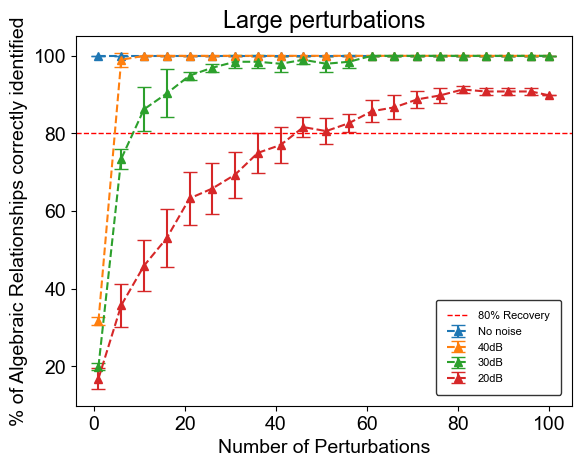

In [66]:
total_relations = 49
from matplotlib import pyplot as plt
for snr, result_df_ in result_dict_up.items():
    # plt.plot(result_df_["#Perturbations"],
    #          (total_relations-result_df_["#Incorrect relationship"])*100/total_relations, '.-', label = snr)
    line_fmt= '-o' if folder_name_1 == "case39bus10gen_onetenthperturb" else '--^'
    plt.errorbar(result_df_["#Perturbations"],
                 (total_relations - result_df_["#Incorrect relationship mean"]) * 100 / total_relations,
                  (result_df_["#Incorrect relationship std"]) * 100 / total_relations,
                 fmt=line_fmt, label=snr, capsize=5)

    # plt.errorbar(x, y_mean, yerr=y_std, fmt='-o', label='Mean with Std Error', capsize=5)
    # plt.axhline(y=10, color='r', linestyle='--', linewidth=1, label='Reference Line')
    # plt.xticks(range(1, len(sing_vals_1)+1, 1))
    # plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
    
plt.axhline(y=80, color='r', linestyle='--', linewidth=1, label='80% Recovery')
    
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Number of Perturbations')
plt.ylabel('% of Algebraic Relationships correctly identified')
plt.legend(
    # loc='lower right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
if folder_name_1 == "case39bus10gen_onetenthperturb":
    plt.title("Small perturbations")
elif folder_name_1 == "case39bus9gen_halfperturb":
    plt.title("Large perturbations")
# plt.legend()
    
plt.savefig('/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/{}.svg'.format(folder_name_1), format='svg', bbox_inches='tight')


In [54]:
# folder_name_1 = "case39bus9gen_halfperturb"
# folder_name_1 = "case39bus10gen_onetenthperturb"

if folder_name_1 == "case39bus10gen_onetenthperturb":
    result_df_small = result_dict_up
elif folder_name_1 == "case39bus9gen_halfperturb":
    result_df_large = result_dict_up

### Combined image

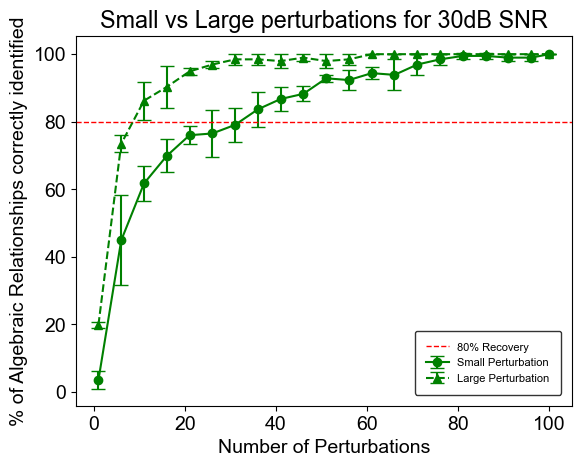

In [62]:
snr_ = "30dB"
total_relations = 49
col = 'green'
# plt.plot(result_df_small[snr_]["#Perturbations"],
#              (total_relations-result_df_small[snr_]["#Incorrect relationship"])*100/total_relations, '.-', label = "Small Perturbation")

# plt.plot(result_df_large[snr_]["#Perturbations"],
#              (total_relations-result_df_large[snr_]["#Incorrect relationship"])*100/total_relations, '.-', label = "Large Perturbation")

plt.errorbar(result_df_small[snr_]["#Perturbations"],
                 (total_relations - result_df_small[snr_]["#Incorrect relationship mean"]) * 100 / total_relations,
                  (result_df_small[snr_]["#Incorrect relationship std"]) * 100 / total_relations,
                 fmt='-o', label = "Small Perturbation", capsize=5, color=col)

plt.errorbar(result_df_large[snr_]["#Perturbations"],
                 (total_relations - result_df_large[snr_]["#Incorrect relationship mean"]) * 100 / total_relations,
                  (result_df_large[snr_]["#Incorrect relationship std"]) * 100 / total_relations,
                 fmt='--^', label = "Large Perturbation", capsize=5, color=col)


plt.axhline(y=80, color='r', linestyle='--', linewidth=1, label='80% Recovery')
    
plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Number of Perturbations')
plt.ylabel('% of Algebraic Relationships correctly identified')

plt.legend(
    # loc='lower right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)

plt.title("Small vs Large perturbations for {} SNR".format(snr_))

plt.savefig('/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/small_vs_large_{}.svg'.format(snr_), format='svg', bbox_inches='tight')


In [45]:
# snr_ = "30dB"
# total_relations = 49

# plt.plot(result_df_small[snr_]["#Perturbations"],
#              (total_relations-result_df_small[snr_]["#Incorrect relationship"])*100/total_relations, '.-', label = "Small Perturbation")

# plt.plot(result_df_large[snr_]["#Perturbations"],
#              (total_relations-result_df_large[snr_]["#Incorrect relationship"])*100/total_relations, '.-', label = "Large Perturbation")



# plt.axhline(y=80, color='r', linestyle='--', linewidth=1, label='80% Recovery')
    
# plt.rcParams['font.family'] = 'Arial'
# # plt.rcParams['font.size'] = 14
# # Set labels for X and Y axes
# plt.xlabel('Number of Perturbations')
# plt.ylabel('% of Algebraic Relationships correctly identified')

# plt.legend(
#     # loc='lower right', 
#     prop={'size': 8},
#     frameon=True,  # Ensure the legend box is visible
#     borderpad=1,  # Padding between the border and the legend content
#     borderaxespad=1,  # Padding between the legend and the axes
#     fancybox=True,  # Rounded border corners (set to False for square corners)
#     edgecolor='black'
# )

# plt.title("Small vs Large perturbations for {} SNR".format(snr_))

# plt.savefig('/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/small_vs_large_{}.svg'.format(snr_), format='svg', bbox_inches='tight')


In [10]:
from matplotlib import pyplot as plt
# noise_percent_list = [0,0.0001,0.001,0.01]
noise_percent_list = [0.001,0.01]

# snr_list = ["No noise", "40dB", "30dB", "20dB"]
snr_list = ["30dB", "20dB"]

result_dict_up= {}
for noise_perc_value, snr in zip(noise_percent_list, snr_list):
    result_dict_up[snr] = pd.read_csv(
        ("/Users/manu_jay/git_repos/DAE-FINDER_dev/Numerical_Example/power_grid/{}/{}_noise_{}.csv".format(
            folder_name_1,folder_name_1, noise_perc_value)))
            

In [11]:
result_dict_up['30dB']

,#Perturbations,#Incorrect relationship mean,#Incorrect relationship std,Noise Level
0,2,46.00000000,0.00000000,0.00100000
1,51,9.00000000,0.00000000,0.00100000
2,100,0.00000000,0.00000000,0.00100000


In [15]:
result_df_["#Incorrect relationship mean"]

0   46.00000000
1    9.00000000
2    0.00000000
Name: #Incorrect relationship mean, dtype: float64

In [16]:
result_df_["#Incorrect relationship std"]

0   0.00000000
1   0.00000000
2   0.00000000
Name: #Incorrect relationship std, dtype: float64

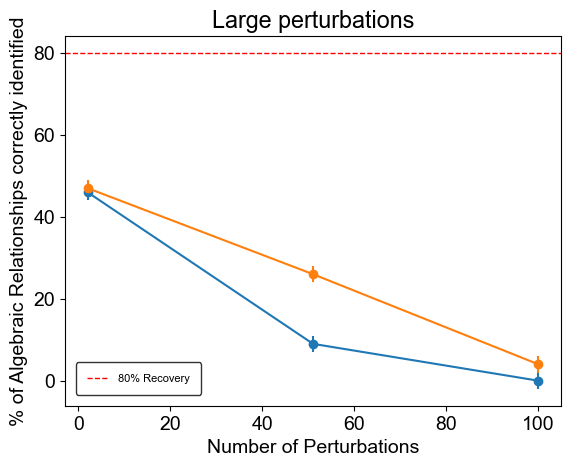

In [24]:

total_relations = 49
from matplotlib import pyplot as plt
for snr, result_df_ in result_dict_up.items():
    # plt.plot(result_df_["#Perturbations"],
    #          (total_relations-result_df_["#Incorrect relationship"])*100/total_relations, '.-', label = snr)
    result_df_["#Incorrect relationship std"] = 2
    plt.errorbar(result_df_["#Perturbations"],
             result_df_["#Incorrect relationship mean"], result_df_["#Incorrect relationship std"], fmt='-o')
                 # '-o', label=snr, capsize=5)

    # plt.errorbar(x, y_mean, yerr=y_std, fmt='-o', label='Mean with Std Error', capsize=5)
    # plt.axhline(y=10, color='r', linestyle='--', linewidth=1, label='Reference Line')
    # plt.xticks(range(1, len(sing_vals_1)+1, 1))
    # plt.ylim(np.log(sing_vals_1)[-1]-1, np.log(sing_vals_1)[0]+1)
    
plt.axhline(y=80, color='r', linestyle='--', linewidth=1, label='80% Recovery')
    
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
# Set labels for X and Y axes
plt.xlabel('Number of Perturbations')
plt.ylabel('% of Algebraic Relationships correctly identified')
plt.legend(
    # loc='lower right', 
    prop={'size': 8},
    frameon=True,  # Ensure the legend box is visible
    borderpad=1,  # Padding between the border and the legend content
    borderaxespad=1,  # Padding between the legend and the axes
    fancybox=True,  # Rounded border corners (set to False for square corners)
    edgecolor='black'
)
if folder_name_1 == "case39bus10gen_onetenthperturb":
    plt.title("Small perturbations")
elif folder_name_1 == "case39bus9gen_halfperturb":
    plt.title("Large perturbations")
# plt.legend()